# Naive Bayes applied to Spam filtering

This notebook was inspired on the tutorial written by Abhjeet Kumar at [appliedmachinelearning.wordpress.com](https://appliedmachinelearning.wordpress.com/2017/01/23/email-spam-filter-python-scikit-learn/). Be sure to go over there and share your appreciation with him for releasing it to the public.

Language is a complex things, composed of numerous element which are bound together through syntax and semantics. Its written format is no different. However, we often can make use of simplistic assumptions which allow us to tackle problems more easily, while still achieving satisfactory results.

In this example we're gonna take some strong simplification steps in order help us tackle the problem classifying an email as spam or not.

## Data set

We're going to be using the Ling Spam corpus data as described in the paper

> I. Androutsopoulos, J. Koutsias, K.V. Chandrinos, George Paliouras, and C.D. Spyropoulos, ["An Evaluation of Naive Bayesian Anti-Spam Filtering"](https://arxiv.org/abs/cs/0006013). In Potamias, G., Moustakis, V. and van Someren, M. (Eds.), Proceedings of the Workshop on Machine Learning in the New Information Age, 11th European Conference on Machine Learning (ECML 2000), Barcelona, Spain, pp. 9-17, 2000.

For more information about it check please visit [this page](http://csmining.org/index.php/ling-spam-datasets.html). You can get the original dataset from the author Ion Androutsopoulos webpage [here](http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz).


## Preparing your Data

Treating data is big component of machine learning and in this tutorial we'll explore some basic approaches. The original data set provides a version pre-filtered for stop words and lemmatization (found in the folder `lemma_stop`).

Stop words are words which appear very often since they are fundamental constructs of the language. Examples include: 'and', 'the', "but", etc... They are often removed since they provide little information in most scenarios.

Lemmatization on the other hand can be (grossly) described as the process of grouping together inflected forms of a word, allowing to be parsed as the same entity. A typical example would be grouping 'walk', 'walked', 'walks', 'walking' under 'walk'.

We're gonna make use of a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation of our emails. Quoting straight from Wikipedia

> The bag-of-words model is a simplifying representation used in natural language processing [...], a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

After extracting all vocabulary (relevant words) from the emails, we will make use of a feature vector which counts the number of occurrences of certain words. As you can imagine this vector will have a huge number of zero entries.

We will organize map each email to the a new row and our features (words) will span the columns of our data matrix.

## Load the Data

In [1]:
import numpy as np

data = np.load('data/lingspam/lingspam.npz')
data.files

['words', 'file_names', 'targets', 'target_names']

- **words**: contains all relevant words present on each email. It's organized as a list of a list of words.
- **file_names**: it's a list of strings with all names of the files, to provide traceability to the original data set.
- **targets**: provides the information regarding if a certain entry is spam or not
- **target_names**: the names of all the classes, in this case 'spam' or 'ham' (not spam).

Let's have a look at some of the changes made on the data set. Here's the original content of a particular email

```
$ cat lingspam_public/lemm_stop/part10/9-5msg2.txt 
Subject: bilingualism

2nd international symposium bilingualism 15-17 april , 1999 ( provisional date ) university newcastle upon tyne , uk 1st announcement submission invite oral poster presentation , aspect bilingualism . paper base empirical research seek forge link between establish field ( e . g . linguistics , psychology , speech & language pathology , sociology , education ) develop sub-field particularly welcome . submission peer-review , anonymously , select grounds originality , clarity , significance finding conclusion . special feature symposium include panel session : ) cross-linguistic study language acquisition disorder ; ius ) bilingual social interaction ; iius ) trilingual ; iv ) grammar code-switch ; v ) childhood bilingualism ; vus ) acquire communication disorder bilingual ; vius ) bilingualism deaf community , round - table \ 145issue identification intervention multilingual / multicultural speech therapy clinic \ 146 . important date : 31 january , 1998 : 2nd announcement 1 september , 1998 : deadline submission abstract 31 october , 1998 : notice acceptance 1 january , 1999 : close date registration further detail , please contact : mr gillian cavagan , isb organise committee , department speech , university newcastle upon tyne , ne1 7ru , uk , e - mail : gillian . cavagan @ ncl . ac . uk ; fax : + 44 ( 0 ) 191 222 6518 ; consult : http : / / www . ncl . ac . uk / ~ nspeech zhu hua editorial assistant international journal bilingulism

```

and here's how that exact email now is represented after processing.


In [2]:
data["file_names"][5]

'9-5msg2.txt'

In [3]:
print(data["words"][5])

['2nd', 'international', 'symposium', 'bilingualism', 'april', '#', 'provisional', 'date', 'university', 'newcastle', 'upon', 'tyne', '1st', 'announcement', 'submission', 'invite', 'oral', 'poster', 'presentation', 'aspect', 'bilingualism', 'paper', 'base', 'empirical', 'research', 'seek', 'forge', 'link', 'between', 'establish', 'field', 'linguistics', 'psychology', 'speech', 'language', 'pathology', 'sociology', 'education', 'develop', 'sub', 'field', 'particularly', 'welcome', 'submission', 'peer', 'review', 'anonymously', 'select', 'grounds', 'originality', 'clarity', 'significance', 'finding', 'conclusion', 'special', 'feature', 'symposium', 'include', 'panel', 'session', 'cross', 'linguistic', 'study', 'language', 'acquisition', 'disorder', 'ius', 'bilingual', 'social', 'interaction', 'iius', 'trilingual', 'grammar', 'code', 'switch', 'childhood', 'bilingualism', 'vus', 'acquire', 'communication', 'disorder', 'bilingual', 'vius', 'bilingualism', 'deaf', 'community', 'round', 'tab

There were two stages of filtering applied to every email

1. All words with less than 3 letter were filtered out. This erases a number of stop words, punctuation and spurious characters.
2. All numbers are assumed equal and replaced by the '#' sign.

The strategy applied in 2. supposedly could also be extended to urls, telephone numbers or money. Unfortunately, the data provided has a very uncommon spacing which makes it challenging to apply this logic.

The script used to preprocess the emails can be found at `data/lingspam/preprocess.py`.

The features need to be organized as columns and each entry needs to be a new row. So the first step is to compose a set of all unique words.

In [4]:
from collections import Counter

words_ctr = Counter()
words_n = 0
for entry in data["words"]:
    words_ctr += Counter(entry)
    words_n += len(entry)
    
print("Number of unique words: %.2E" % float(len(words_ctr)))
print("Number of words: %.2E" % float(words_n))


Number of unique words: 4.99E+04
Number of words: 7.80E+05


This tells us there are close to 50k unique words in our 3k emails. Let's check the top most common words.

<IPython.core.display.Javascript object>


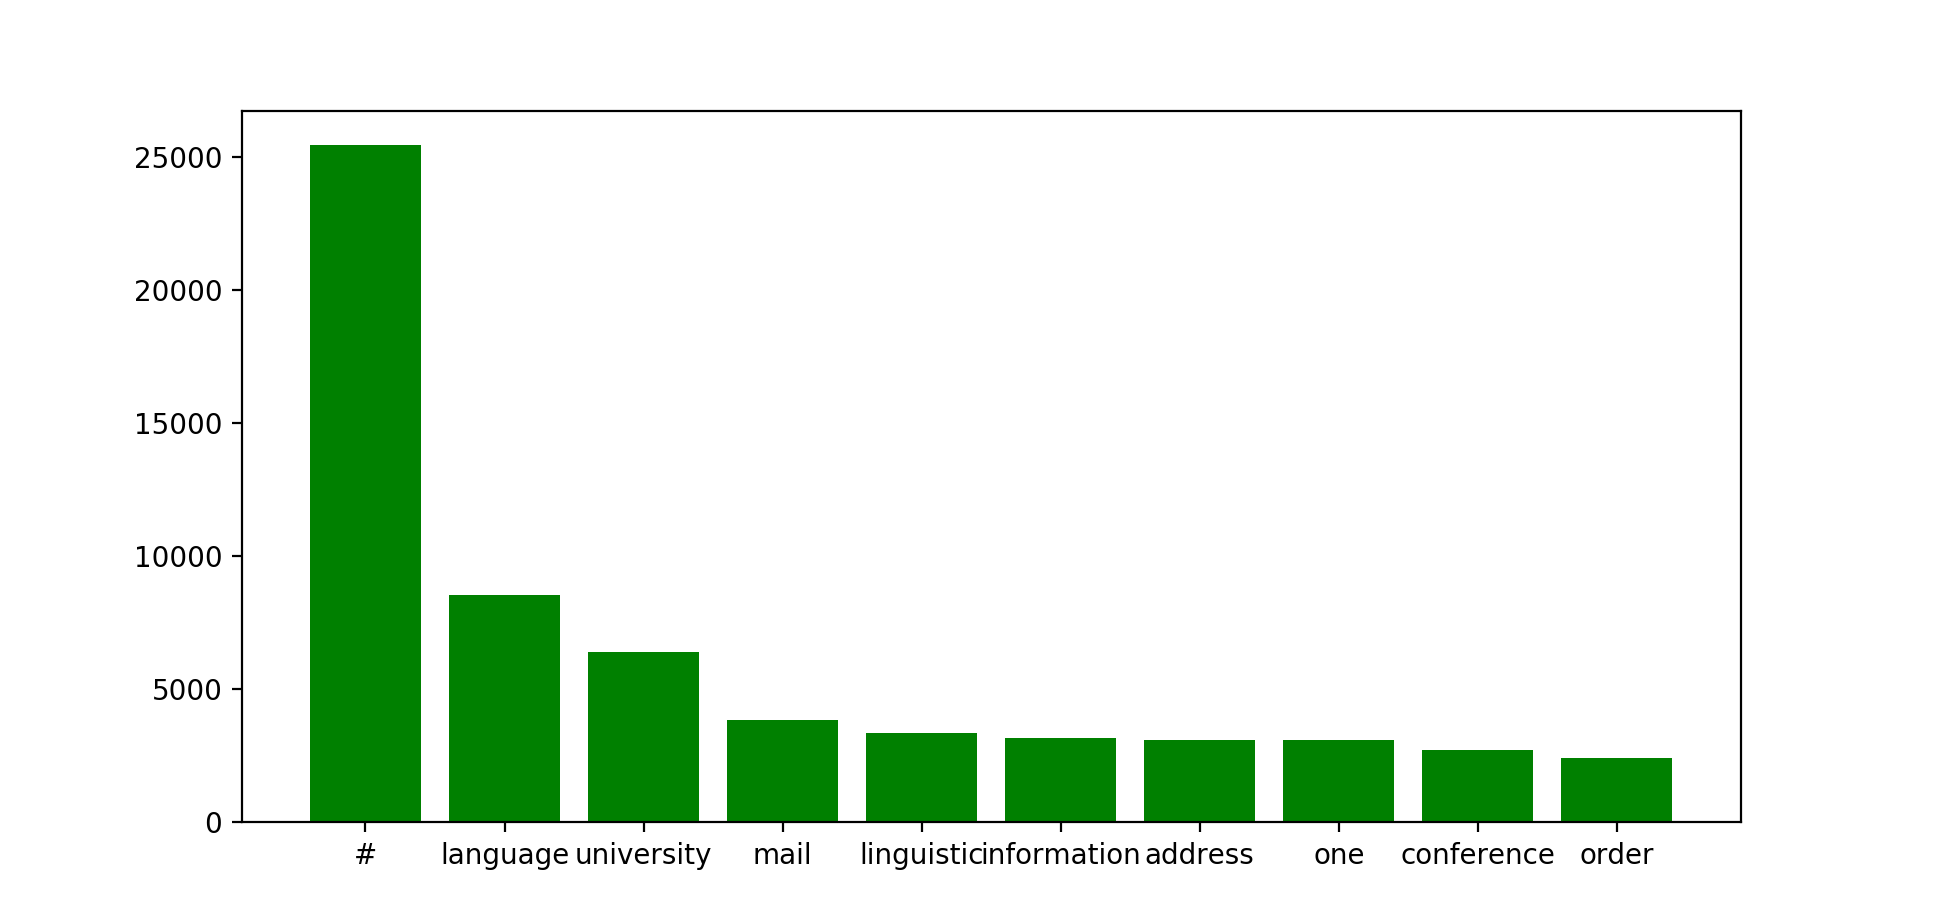

In [6]:
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib notebook

common = OrderedDict(words_ctr.most_common())


n = 10
plt.bar(range(0,n), list(common.values())[0:n], color='g')
plt.xticks(range(0,n), list(common.keys())[0:n])
plt.show()

50k words is already a reasonably big number and it's filled with many words which have very low occurrence rates. 

How many unique words do we need to capture 90% of the total words occurences?

In [7]:
# word rate threshold
rate = 0.9
threshold = rate * words_n
acc = 0
for i, item in enumerate(common.items()):
    if acc > threshold:
        break
    acc += item[1]
    
print("%d unique words make up %d%% of the word occurrences." % (i, int(rate*100)))
print("That's %.1f%% of the total amount of unique words." % (i*100/len(words_ctr)))

9451 unique words make up 90% of the word occurrences.
That's 18.9% of the total amount of unique words.


That's already quite the reduction.

Now we need to write function to construct our feature vector from a preprocessed email. Let's recover the processed version of our example email.

In [8]:
print(data["words"][5])

['2nd', 'international', 'symposium', 'bilingualism', 'april', '#', 'provisional', 'date', 'university', 'newcastle', 'upon', 'tyne', '1st', 'announcement', 'submission', 'invite', 'oral', 'poster', 'presentation', 'aspect', 'bilingualism', 'paper', 'base', 'empirical', 'research', 'seek', 'forge', 'link', 'between', 'establish', 'field', 'linguistics', 'psychology', 'speech', 'language', 'pathology', 'sociology', 'education', 'develop', 'sub', 'field', 'particularly', 'welcome', 'submission', 'peer', 'review', 'anonymously', 'select', 'grounds', 'originality', 'clarity', 'significance', 'finding', 'conclusion', 'special', 'feature', 'symposium', 'include', 'panel', 'session', 'cross', 'linguistic', 'study', 'language', 'acquisition', 'disorder', 'ius', 'bilingual', 'social', 'interaction', 'iius', 'trilingual', 'grammar', 'code', 'switch', 'childhood', 'bilingualism', 'vus', 'acquire', 'communication', 'disorder', 'bilingual', 'vius', 'bilingualism', 'deaf', 'community', 'round', 'tab

Our feature vector is a vector in which the number of occurences for each word in the email is counted. Since we chose to place the most common words in the first positions we should see most of the non-zero entries in the first columns.

**Important**: typical Naive Bayes approaches of the spam classification are usually only interested in understanding if a certain word appears in a document or not. This makes it easier to write efficient code and the results are practically equivalent.

In [9]:
# Let's redefine common to only retrieve the amount of unique words we picked before
n = 9451
common = OrderedDict(words_ctr.most_common(n))

kidx = dict(zip(common.keys(), range(0, len(common))))
unique_words = set(common.keys())

def extract_features(words:list):
    valid_words = [item for item in words if item in unique_words]
    features = np.zeros(len(unique_words), dtype=np.uint32)
    for key, val in Counter(valid_words).items():
        features[kidx[key]] = val
    return features
    
print(extract_features(data["words"][5]))

    

[9 2 2 ... 0 0 0]


Looks like it's working. Let's process the rest of the emails and construct our data matrix.

In [10]:
len(data['targets'])

2893

In [11]:
X = np.empty((len(data['targets']), len(unique_words)), dtype=np.uint32)

for i, item in enumerate(data["words"]):
    X[i,:] = extract_features(item)

X

array([[12,  5,  0, ...,  0,  0,  0],
       [11,  0,  2, ...,  0,  0,  0],
       [20,  1, 30, ...,  0,  0,  0],
       ...,
       [10,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## Splitting the dataset

The next step it to split our data into training and a test sets, to see how good it performs. A typical split is using 70% of your data for training and 30% to test the results of your training. Scikit provides a method to shuffle our data set and perform the split quickly.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, data["targets"], test_size=0.30)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2025, 9451)
X_test:  (868, 9451)
y_train:  (2025,)
y_test:  (868,)


## Breaking Down Naive Bayes

We want a classifier which provides us with

\begin{equation}
\underset{c}{\operatorname{argmax}} P(c|\textbf{f})
\end{equation}

Applying the Bayes rule we have

\begin{eqnarray}
\underset{c}{\operatorname{argmax}} P(c|\textbf{f}) & = & \underset{c}{\operatorname{argmax}} \alpha P(\textbf{f}|c) P(c)
\end{eqnarray}

the "naive" term comes from the fact that we'll consider each feature is conditionally independent if the class is known. That way the expression above converts into

\begin{eqnarray}
\underset{c}{\operatorname{argmax}} P(c|\textbf{f}) & = & \underset{c}{\operatorname{argmax}} P(c) \prod_{i=1}^{N} P(f_i|c)
\end{eqnarray}

Having multiple products of values between 0 and 1 is bound to have numerical problems so usually the log probability is used 

\begin{eqnarray}
\underset{c}{\operatorname{argmax}} \log P(c|\textbf{f}) & = & \underset{c}{\operatorname{argmax}} \log P(c)  + \sum_{i=1}^{N} \log P(f_i|c)
\end{eqnarray}


How to compute $P(c)$ and $P(f_i|c)$? Compute the MLE over the empirical distribution provided by the training set.

## How to do it with Scikit

In [13]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
from sklearn.metrics import confusion_matrix

res = nb.predict(X_test)

confusion_matrix(y_test, res)

array([[715,   6],
       [  0, 147]])

Quick as usual!

## Let's do it ourselves

Let's just care about which words appear or not in each class of emails.

In [15]:
# creating the masks
m_spam = y_train
m_ham = np.logical_not(m_spam)

# first row conditioned on the spam class, second on the ham
X_b = X_train > 0
prob_features = np.array((np.mean(X_b[m_spam,:],axis=0), np.mean(X_b[m_ham,:],axis=0)))
prob_not_features = 1 - prob_features

# Compute the probability of our classes
prob_spam = np.mean(m_spam)
prob_ham = 1 - prob_spam

Allowing 0 probability features is not good idea. In this particular case it makes the $\log$ explode. The practical workaround is to give an extremely low probability e.g.: assume "it appeared once" in the entire training data set.

In [16]:
def classify(fv):
    ps = np.log(prob_spam)\
         + np.sum(np.log(np.maximum(prob_features[0,fv], 1/len(m_spam))))\
         + np.sum(np.log(np.maximum(prob_not_features[0,np.logical_not(fv)], 1/len(m_spam))))
    ph = np.log(prob_ham)\
         + np.sum(np.log(np.maximum(prob_features[1,fv], 1/len(m_ham))))\
         + np.sum(np.log(np.maximum(prob_not_features[1,np.logical_not(fv)], 1/len(m_ham))))
    return ps > ph, ps, ph

# Prepare the confusion matrix
conf = np.zeros([2,2], dtype=np.uint32)

for i, sample in enumerate(X_test):
    spam, _, _ = classify(sample > 0)
    conf[int(spam), int(y_test[i])] += 1

conf

array([[720,   2],
       [  1, 145]], dtype=uint32)

## Let's take it a step further

What if we compute the actual probability mass function taking into account the number of occurences each word has in each email? Will we get better results?

In [17]:
dist_s = []
dist_h = []

def compute_pmf(array):
    values, counts = np.unique(array, return_counts=True)
    pmf = np.zeros(np.max(values) + 1)
    total = np.sum(counts)
    if total > 0:
        pmf[values] = counts / total
    return pmf

for col in X_train.T:
    # Spam pmfs
    dist_s.append(compute_pmf(col[y_train]))
    
    # Ham pmfs
    dist_h.append(compute_pmf(col[np.logical_not(y_train)]))
    

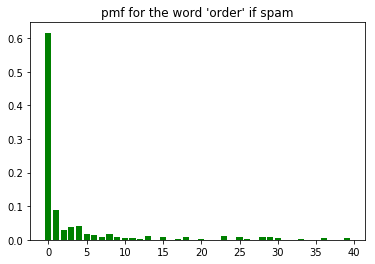

In [18]:
%matplotlib inline
# Let's visualize the pmf of the 10th most common word
i = 9
plt.bar(range(0, len(dist_s[i])), dist_s[i], color="g")
plt.title("pmf for the word '%s' if spam" % list(kidx)[i])
plt.show()

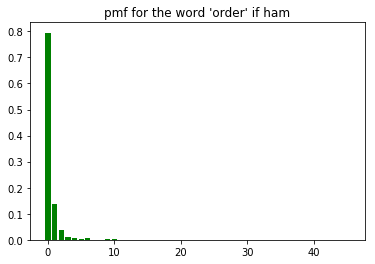

In [19]:
plt.bar(range(0, len(dist_h[i])), dist_h[i], color="g")
plt.title("pmf for the word '%s' if ham" % list(kidx)[i])
plt.show()


In [20]:
print("Probability of spam: %.2f%%" % (prob_spam * 100))
print("Probability of ham: %.2f%%" % (prob_ham * 100))

Probability of spam: 16.49%
Probability of ham: 83.51%


In [21]:
# Let's write the actual classifier
def classify(array):
    # spam
    ps = np.log(prob_spam)
    ph = np.log(prob_ham)
    for i in range(0,len(array)):
        ps += np.log(max([dist_s[i][array[i]], 1/len(kidx)])) if (array[i] < len(dist_s[i])) else np.log(1/len(kidx))
        ph += np.log(max([dist_h[i][array[i]], 1/len(kidx)])) if (array[i] < len(dist_h[i])) else np.log(1/len(kidx))
    return ps > ph, ps, ph

# Prepare the confusion matrix
conf = np.zeros([2,2], dtype=np.uint32)

for i, sample in enumerate(X_test):
    spam, _, _ = classify(sample)
    conf[int(spam), int(y_test[i])] += 1

conf

array([[721,   6],
       [  0, 141]], dtype=uint32)

Was it worth it? Ocasionally it yields, better results so, just from the educational perspective. Just follow the usual approach.

## Issues

If you run into troubles or find mistakes, bugs, please open an issue on the [issue tracker](https://github.com/SergioRAgostinho/bootstrap-ml/issues).
